In [2]:
import pyvisa as pv
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio   
import pickle
import scipy.signal
from tqdm.notebook import tqdm, trange
from scipy.special import erfc

from optic.comm.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample
from optic.comm.metrics import signal_power
from optic.plot import eyediagram
plt.rcParams["figure.figsize"] = (12,6)


# Funçoes
exemplo: myScope.WriteString ":ACQuire:COMPlete 100"  
```text

*RST (Reset) pg 246  
:AUToscale (:AUToscale:CHANnels <value>) pg 263  
:BLANk (desligar canal) pg 268  
:VIEW (mostra 1 canal) pg 300  
:DIGitize (display das ondas?) pg 270  
:RUN (começa a plotar os sinais) pg 294  
:STOP (para de plotar) pg 298  
:SINGle (plota 1 trigger) pg 296  
:ACQuire ( configura o tipo de aquisiçao) (normalmente  :ACQuire:TYPE NORMal ) pg 302  
:CHANnel1? (recebe informações do canal) pg 346  
:CHANnel<n>:DISPlay (liga ou desliga um canal) pg 350  
:CHANnel<n>:OFFSet (offset do canal) pg 354  
:CHANnel<n>:RANGe <range>[<suffix>] ( range em y em V ou mV) pg 370  
:CHANnel<n>:SCALe (escala em y em V ou mV) pg 371  
```

In [101]:
scope.close()
rm.close()


In [143]:
import pyvisa
rm = pyvisa.ResourceManager()
print(rm.list_resources())
scope = rm.open_resource('USB0::0x2A8D::0x1768::MY55440748::0::INSTR')

('USB0::0x0957::0x5707::MY53802202::0::INSTR', 'USB0::0x2A8D::0x1768::MY55440748::0::INSTR', 'USB0::0x1AB1::0x0646::DG9R261500165::0::INSTR')


In [162]:
def ConfigurarScope(scope,tempo,canais,vDivisao,impedancia,trigger,offset):
    scope.write('trigger:mode edge')
    scope.write(f'timebase:range {tempo}')
    scope.write(':CHANnel1:DISPlay 0')
    scope.write(':CHANnel2:DISPlay 0')
    scope.write(':CHANnel3:DISPlay 0')
    scope.write(':CHANnel4:DISPlay 0')
    for i in range(len(canais)):
        scope.write(f':CHANnel{canais[i]}:DISPlay 1')
        scope.write(f'trigger:level channel{canais[i]}, {trigger[i]}')
        scope.write(f'channel{canais[i]}:impedance {impedancia[i]}')
        scope.write(f':CHANnel{canais[i]}:OFFSet {offset[i]}')
        scope.write(f'CHANnel{canais[i]}:SCALe {vDivisao[i]}')

def AdquirirOnda(scope,canal):
    if canal == 'FFT':
        scope.write(':WAVeform:SOURce FFT')
    else:
        scope.write(f'waveform:source channel{canal}')
    scope.write('waveform:format byte')
    
    dados = scope.query_binary_values('waveform:data?', datatype='B')
    nDados = len(dados)

    tInicial = float(scope.query('waveform:xorigin?'))
    Δt = float(scope.query('waveform:xincrement?'))

    yIncial = float(scope.query('waveform:yorigin?'))
    Δy = float(scope.query('waveform:yincrement?'))
    yReferencia = float(scope.query('waveform:yreference?'))
    
    
    t = np.linspace(tInicial,tInicial + Δt*nDados,nDados,endpoint=0)
    y = (np.array(dados) - yReferencia)*Δy  + yIncial

    return t,y
def ConfigFFT(scope,canal,escaladB,fstart,fstop):
    scope.write(f':FFT:SOURce{canal}')
    scope.write(f':FFT:SCALe {escaladB}')
    scope.write(f':FFT:FREQuency:STARt {fstart}')
    scope.write(f':FFT:FREQuency:STOP {fstop}')
    scope.write(':FFT:DMODe AVERage')
    scope.write(':FFT:DISPlay 1')

Text(0.5, 1.0, '5 vpp, f = 80MHz (Limite do emprestado)')

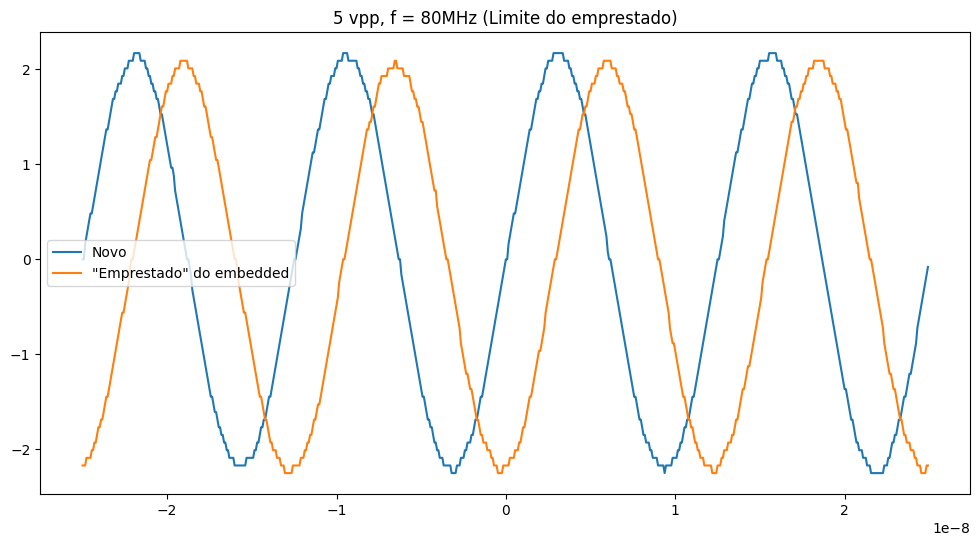

In [142]:
#scope.write('*rst')
#scope.query('*OPC?')
tempo = 0.0002e-3/8
canais = np.array([2,3])
vDivisao = np.array([2,2])
impedancia = np.array(['ONEMeg ','FIFTy'])
trigger = np.array([0,0])
offset = np.array([0,0])
ConfigurarScope(scope,tempo,canais,vDivisao,impedancia,trigger,offset)
scope.write('digitize')
t,y = AdquirirOnda(scope,2)
plt.plot(t,y,label='Novo')
t,y = AdquirirOnda(scope,3)
plt.plot(t,y,label='"Emprestado" do embedded')
plt.legend()
plt.title('5 vpp, f = 80MHz (Limite do emprestado)')

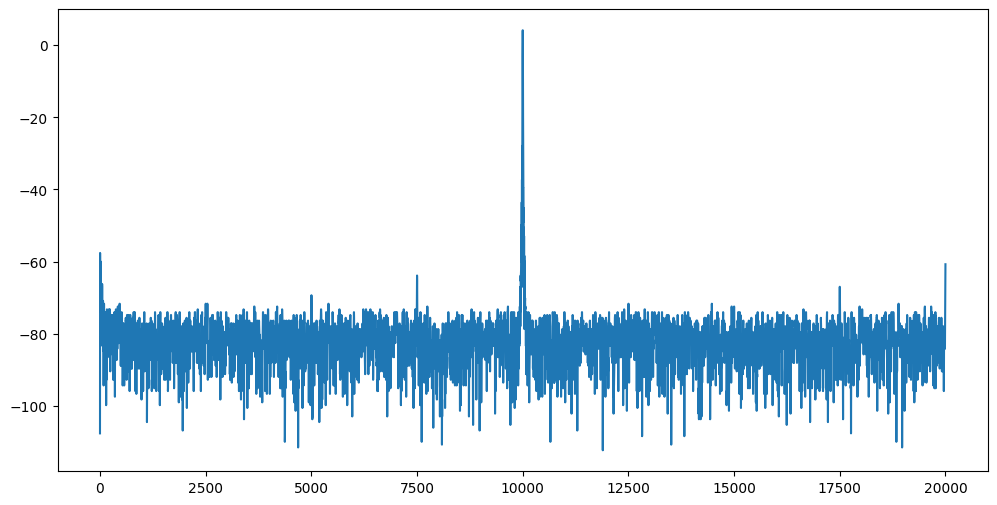

In [161]:

time.sleep(2)
scope.write(':WAVeform:SOURce FFT')
scope.write('waveform:format byte')

dados = scope.query_binary_values('waveform:data?', datatype='B')
nDados = len(dados)

tInicial = float(scope.query('waveform:xorigin?'))
Δt = float(scope.query('waveform:xincrement?'))

yIncial = float(scope.query('waveform:yorigin?'))
Δy = float(scope.query('waveform:yincrement?'))
yReferencia = float(scope.query('waveform:yreference?'))


t = np.linspace(tInicial,tInicial + Δt*nDados,nDados,endpoint=0)
y = (np.array(dados) - yReferencia)*Δy  + yIncial
plt.plot(t,y)

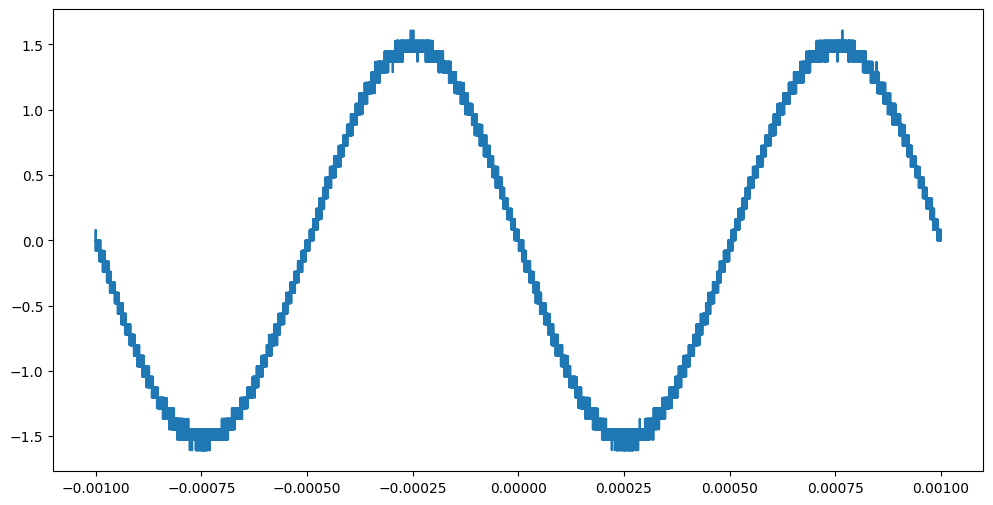

In [124]:
plt.plot(t,y)

In [108]:
#scope.write('*rst')

vRange = 4 # Voltage range on the scope screen (vertical axis range)
tRange = 4e-3 # Time range on the scope screen (horizontal axis)
# If the signal is a sine wave with frequency f=10^5 Hz, it will fit 
# 5 wave paeriods in the scope screen.
trigLevel = 0
ch = 2
chImpedance = 'fifty'


# setup up vertical and horizontal ranges (amplitude and time axis)
scope.write(f'channel{ch}:range {vRange}') # CHANnel<N>:RANGe <range_value>
scope.write(f'timebase:range {tRange}') # “TIMebase:RANGe <full_scale_range>
# setup up trigger mode and level
scope.write(f'trigger:mode edge') # TRIGger:MODE <mode>
scope.write(f'trigger:level channel{ch}, {trigLevel}') # TRIGger:LEVel CHANnel<N>, <level>
scope.write(f'channel{ch}:impedance {chImpedance}')


scope.write(':CHANnel1:DISPlay 0')
scope.write(':CHANnel2:DISPlay 1')
scope.write(':CHANnel1:SCALe 1')
scope.write(':CHANnel2:SCALe 2')
scope.write('digitize')
scope.write(f'waveform:source channel2')
scope.write('waveform:format byte')
data = scope.query_binary_values('waveform:data?', datatype='B') 

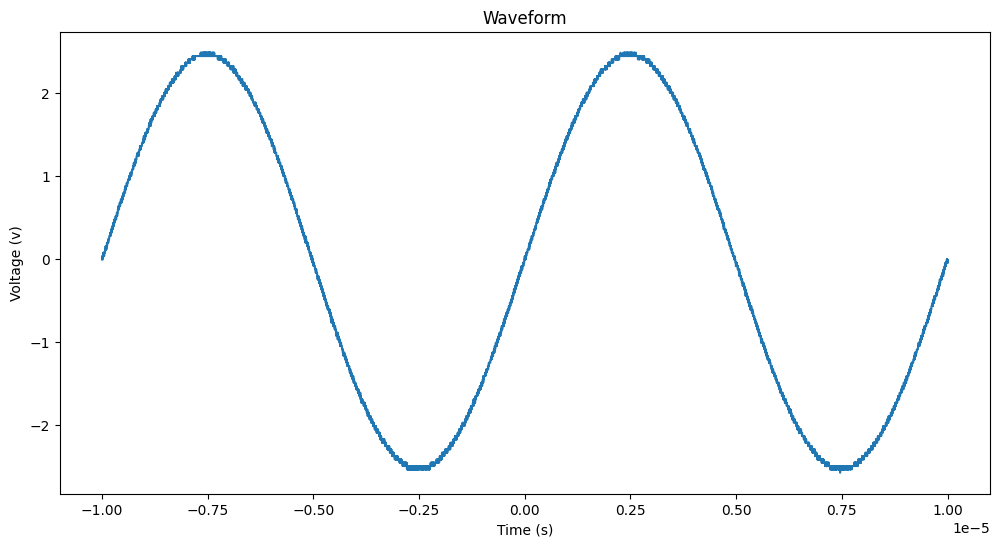

In [63]:

# transfer binary waveform data from scope
data = scope.query_binary_values('waveform:data?', datatype='B') 
# Instrument binary data is unsigned (B). In case of signed binary data, 
# use datatype='b'.

# get the instrument parameter to scale the data correctly
xIncrement = float(scope.query('waveform:xincrement?'))
xOrigin = float(scope.query('waveform:xorigin?'))
yIncrement = float(scope.query('waveform:yincrement?'))
yOrigin = float(scope.query('waveform:yorigin?'))
yReference = float(scope.query('waveform:yreference?'))
length = len(data)

# applying scaling factors
# standard syntax

time = []
wfm = []

# First, construct the X axis (it goes from -xOrigin to +xOrigin)
	
time = np.linspace(xOrigin,xOrigin + xIncrement*length,length,endpoint=0)
wfm = (np.array(data) - yReference)*yIncrement  + yOrigin


# plot waveform data

plt.plot(time, wfm)
plt.title('Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (v)')
plt.show()